# PS1-3 Poisson Regression

In [116]:
import numpy as np
import src.util as util
from src.linear_model import LinearModel
import matplotlib.pyplot as plt

In [117]:
ds4_train_path='./data/ds4_train.csv'
ds4_val_path='./data/ds4_valid.csv'
ps1_3d_pred_path = './output/p03d_pred.txt'

In [118]:
# load data
x_train, y_train = util.load_dataset(ds4_train_path, add_intercept=True)
x_val, y_val = util.load_dataset(ds4_val_path, add_intercept=True)

### (a) Prove that the Poisson distribution is a member of the exponential family.

Exponential family distributions can be expressed in the form:
$$p(y|\eta) = b(y)\exp{\left[\eta^TT(y)-a(\eta)\right]}.$$

Poisson distribution can be transformed into this form.

\begin{align*}
p(y; \lambda) &= \frac{e^{-\lambda}\lambda ^y}{y!} \\
&= \frac{1}{y!} e^{-\lambda} e^{y \ln\lambda} \\
&= \frac{1}{y!}\exp\left(y\ln\lambda-\lambda\right).
\end{align*}

Thus, Poisson distribution is a member of the exponential family with:
- $b(y) = \frac{1}{y!}$,
- $T(y) = y$,
- $\eta = \ln\lambda$,
- $a(\eta) = \lambda = e^{\eta}$.

### (b) Canonical response function for Poisson regression.

Recall GLMs assume that 
-   $y|x; \theta$ is a member of the exponential family with natural parameter $\eta$.
-   $\eta=\theta^Tx$.
-   Canonical response function $h_\theta(x)=\mathbb E(y|x;\theta)$.

According to the properties of Poisson distribution:

\begin{align*}
\mathbb E(y|x) = \lambda = e^{\eta} = e^{\theta^Tx}.
\end{align*}

Thus,
$$
h_\theta(x) = \mathbb E(y|x;\theta) = e^{\theta^Tx}.
$$

### (c) MLE for Poisson regression.

Likelihood for Poisson regression is given by:

\begin{align*}
L(\theta) &= \prod_{i=1}^m p(y^{(i)}|x^{(i)}; \theta) \\
&= \prod_{i=1}^m \frac{e^{-h_\theta(x^{(i)})}h_\theta(x^{(i)})^{y^{(i)}}}{y!}.
\end{align*}

Thus, the log-likelihood is:
$$l(\theta) = \sum_{i=1}^m \left(-h_\theta(x^{(i)}) + y^{(i)}\ln h_\theta(x^{(i)}) - \ln(y!)\right).$$

Derivative of the log-likelihood w.r.t. $\theta_j$ is:

\begin{align*}
\frac{\partial l(\theta)}{\partial \theta_j} &= \sum_{i=1}^m \left(-h_\theta(x^{(i)})x^{(i)}_j + y^{(i)}x^{(i)}_j\right) \\
&= \sum_{i=1}^m x^{(i)}_j\left(y^{(i)} - h_\theta(x^{(i)}) \right).

\end{align*}

The gradient ascent update rule for $\theta_j$ is:

$$
\theta_j := \theta_j + \alpha \sum_{i=1}^m x^{(i)}_j\left(y^{(i)} - h_\theta(x^{(i)}) \right).

### (d) Implement Poisson regresson.

Codes below are modified from `./src/p03d_poisson.py`. 

`ps1_3d_main` will not be called in this notebook.

In [119]:
def ps1_3d_main(lr, train_path, eval_path, pred_path):
    """Problem 3(d): Poisson regression with gradient ascent.

    Args:
        lr: Learning rate for gradient ascent.
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    # Load training set
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)
    # The line below is the original one from Stanford. It does not include the intercept, but this should be added.
    # x_train, y_train = util.load_dataset(train_path, add_intercept=False)

    # *** START CODE HERE ***
    # Fit a Poisson Regression model
    clf = PoissonRegression(step_size=lr)
    clf.fit(x_train, y_train)
    # Run on the validation set, and use np.savetxt to save outputs to pred_path
    x_val, y_val = util.load_dataset(eval_path, add_intercept=True)
    y_val_pred = clf.predict(x_val)
    np.savetxt(pred_path, y_val_pred)
    # *** END CODE HERE ***


class PoissonRegression(LinearModel):
    """Poisson Regression.

    Example usage:
        > clf = PoissonRegression(step_size=lr)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run gradient ascent to maximize likelihood for Poisson regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        def h(x):
            """Canonical response function.

            Args:
                x: Training example inputs. Shape (m, n).

            Returns:
                $h(x) = e^{\\theta^Tx}$. Shape (m, 1)
            """
            return np.exp(x @ self.theta)
        
        def gradient(x, y):
            """Compute the gradient of log-likelihood w.r.t. \\theta.

            Args:
                x: Training example inputs. Shape (m, n).
                y: Training example labels. Shape (m,).

            Returns:
                Gradient of log-likelihood w.r.t. \\theta. Shape (n, 1).
            """
            grad = x * (y.reshape(-1, 1) - h(x))
            return grad.sum(axis=0).reshape(-1, 1)

        m, n = x.shape

        if self.theta is None:
            self.theta = np.zeros((n, 1))
        
        iter_cnt = 0
        grad = gradient(x, y)
        while grad.max() > self.eps and iter_cnt < self.max_iter:
            self.theta = self.theta + self.step_size * grad # gradient ascent
            iter_cnt += 1
            grad = gradient(x, y)

        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Floating-point prediction for each input, shape (m,).
        """
        # *** START CODE HERE ***
        def h(x):
            """Canonical response function.

            Args:
                x: Training example inputs. Shape (m, n).

            Returns:
                $h(x) = e^{\\theta^Tx}$. Shape (m, 1)
            """
            return np.exp(x @ self.theta)
        return h(x).reshape(-1)
        # *** END CODE HERE ***


In [120]:
lr = 1e-11
poisson_clf = PoissonRegression(step_size=lr, max_iter=50000)
poisson_clf.fit(x_train, y_train)

In [128]:
y_train_pred = poisson_clf.predict(x_train)
np.abs((y_train - y_train_pred)).mean()

1212.3062447137868

In [129]:
y_val_pred = poisson_clf.predict(x_val)
np.abs((y_val - y_val_pred)).mean()

1240.0425817516223

In [130]:
# plot results
def plot(y_label, y_pred, title):
    plt.plot(y_label, 'ro', label='label')
    plt.plot(y_pred, 'bx', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

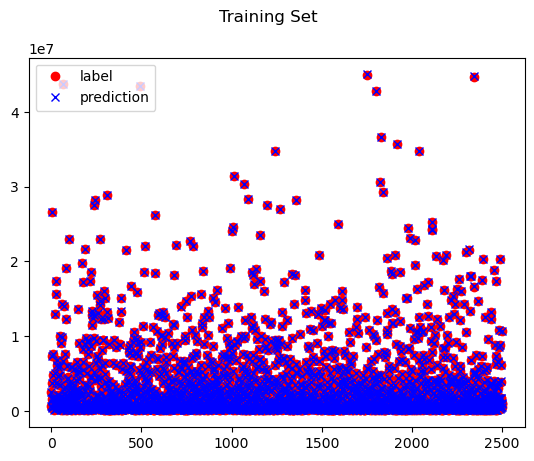

In [132]:
plot(y_train, y_train_pred, 'Training Set')

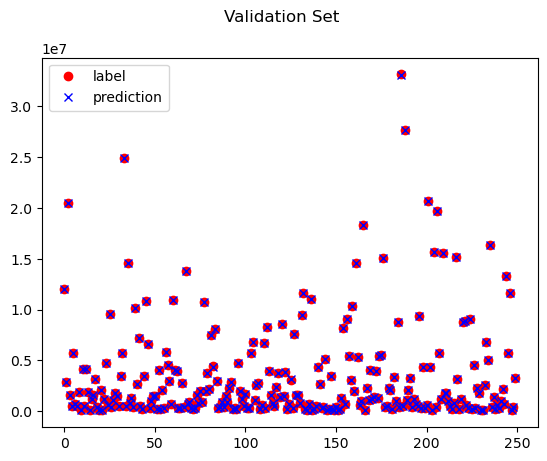

In [131]:
plot(y_val, y_val_pred, 'Validation Set')